<a href="https://colab.research.google.com/github/grabuffo/BrainStim_ANN_fMRI_HCP/blob/main/notebooks/Extract_TMS_fMRI_data.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
# --- One-cell notebook: extract Tian-50 + Schaefer-400 parcel time series (Tian first) + build nested dict with metadata ---

import os, re, glob, json
import numpy as np
import pandas as pd
import nibabel as nib

from nilearn.maskers import NiftiLabelsMasker
from nilearn.image import load_img, resample_to_img

# =========================
# CONFIG (this was done on local)
# =========================
BASE_DIR   = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
DERIV_DIR  = os.path.join(BASE_DIR, "derivatives")

# Atlases
SCHAEFER_PATH = os.path.join(BASE_DIR, "atlases", "Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")
TIAN_PATH     = os.path.join(BASE_DIR, "atlases", "Tian_Subcortex_S3_3T.nii")
TIAN_LABELS   = os.path.join(BASE_DIR, "atlases", "Tian_Subcortex_S3_3T_label.txt")

SUBJECTS_TXT = os.path.join(BASE_DIR, "subjects_all.txt")

EVENTS_PATH_CANDIDATES = [os.path.join(BASE_DIR, "task-stim_events.tsv"), "/mnt/data/task-stim_events.tsv"]
PARTICIPANTS_PATH_CANDIDATES = [os.path.join(BASE_DIR, "participants.tsv"), "/mnt/data/participants.tsv"]

# TR metadata:
TR_REST_S  = 2.0
TR_STIM_S  = 2.4
TR_STIM_ACTUAL_S = 2.1
TR_STIM_GAP_S    = 0.3

STANDARDIZE = "zscore_sample"
DETREND     = True

# =========================
# LOAD SUBJECT LIST
# =========================
with open(SUBJECTS_TXT, "r") as f:
    subjects_all = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("#")]

# =========================
# HELPERS
# =========================
def first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    return None

def load_json_if_exists(path):
    if path and os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

# def parse_task_and_coords_from_fname(fname):
#     if "task-rest" in fname:
#         return "task-rest", None
#     if "task-stim" in fname:
#         m = re.search(r"task-stim(\-?\d+)x(\-?\d+)x(\-?\d+)", fname)
#         if not m:
#             raise RuntimeError(f"Cannot parse stimulation coordinates from filename: {fname}")
#         return "task-stim", np.array(list(map(int, m.groups())), dtype=int)
#     return None, None

def parse_task_and_coords_from_fname(fname):
    if "task-rest" in fname:
        return "task-rest", None

    if "task-stim" in fname:
        # capture three tokens separated by x; each token can be:
        #   46
        #   -18
        #   Minus18
        m = re.search(r"task-stim([A-Za-z\-0-9]+)x([A-Za-z\-0-9]+)x([A-Za-z\-0-9]+)", fname)
        if not m:
            raise RuntimeError(f"Cannot parse stimulation coordinates from filename: {fname}")

        def tok2int(tok):
            tok = tok.replace("Minus", "-").replace("minus", "-")
            return int(tok)

        x, y, z = (tok2int(t) for t in m.groups())
        return "task-stim", np.array([x, y, z], dtype=int)

    return None, None


def find_bold_files(func_dir):
    patterns = [
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii",
    ]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(func_dir, pat)))
    return sorted(set(files))

def infer_tr_from_json(json_sidecar, fallback_tr):
    if isinstance(json_sidecar, dict):
        rt = json_sidecar.get("RepetitionTime", None)
        if rt is not None:
            try:
                return float(rt)
            except Exception:
                pass
    return float(fallback_tr)

def stimulated_parcel_from_mni(atlas_img, mni_coord, n_parcels_expected=None):
    """
    atlas_img: labels image in same grid as BOLD (resampled)
    mni_coord: (x,y,z) in mm
    Returns: (stim_mask, label_int) where stim_mask has length = max label in atlas (or n_parcels_expected)
    """
    data = atlas_img.get_fdata()
    inv_aff = np.linalg.inv(atlas_img.affine)
    ijk = nib.affines.apply_affine(inv_aff, mni_coord)
    ijk = np.round(ijk).astype(int)

    if np.any(ijk < 0) or np.any(ijk >= np.array(data.shape)):
        return None, None

    label = int(data[tuple(ijk)])
    if label == 0:
        return None, None

    n_parcels = int(data.max())
    if n_parcels_expected is not None:
        n_parcels = int(n_parcels_expected)

    stim = np.zeros(n_parcels, dtype=int)
    stim[label - 1] = 1
    return stim, label

def load_tian_labels(path_txt):
    """
    Reads label file; returns list length 50 (no background) if possible.
    """
    with open(path_txt, "r") as f:
        labels = [ln.strip() for ln in f if ln.strip()]
    # Some label files include a background line; drop it if present
    if labels and labels[0].lower() in ("background", "bg", "0"):
        labels = labels[1:]
    # Prefix for clarity
    labels = [f"SC_{x}" for x in labels]
    return labels

In [ ]:

# =========================
# LOAD AUX FILES
# =========================
events_path = first_existing(EVENTS_PATH_CANDIDATES)
participants_path = first_existing(PARTICIPANTS_PATH_CANDIDATES)

stim_events = pd.read_csv(events_path, sep="\t") if events_path is not None else None
participants = pd.read_csv(participants_path, sep="\t") if participants_path is not None else None

# Sanity checks
for pth, name in [(DERIV_DIR,"DERIV_DIR"), (SCHAEFER_PATH,"Schaefer atlas"), (TIAN_PATH,"Tian atlas"), (TIAN_LABELS,"Tian labels")]:
    if not os.path.exists(pth):
        raise FileNotFoundError(f"{name} not found: {pth}")

# Load atlas images + labels
schaefer_img_native = load_img(SCHAEFER_PATH)
tian_img_native     = load_img(TIAN_PATH)

tian_labels = load_tian_labels(TIAN_LABELS)
if len(tian_labels) != 50:
    print(f"Warning: Tian labels length is {len(tian_labels)} (expected 50). Continuing anyway.")


In [ ]:
# --- One-cell notebook: extract Tian-50 + Schaefer-400 (Tian first) and store ALL runs per subject/task ---
# Output structure:
#   dataset[sub_id]['task-rest'][0] -> {'time series', 'metadata'}
#   dataset[sub_id]['task-stim'][0] -> {'time series', 'metadata', 'target', 'stim time'}
# where keys 0,1,2,... index different sessions/runs within each task.

import os, re, glob, json, pickle
import numpy as np
import pandas as pd
import nibabel as nib

from nilearn.maskers import NiftiLabelsMasker
from nilearn.image import load_img, resample_to_img

# =========================
# CONFIG
# =========================
BASE_DIR   = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
DERIV_DIR  = os.path.join(BASE_DIR, "derivatives")

SCHAEFER_PATH = os.path.join(BASE_DIR, "atlases", "Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")
TIAN_PATH     = os.path.join(BASE_DIR, "atlases", "Tian_Subcortex_S3_3T.nii")
TIAN_LABELS   = os.path.join(BASE_DIR, "atlases", "Tian_Subcortex_S3_3T_label.txt")

SUBJECTS_TXT = os.path.join(BASE_DIR, "subjects_all.txt")

EVENTS_PATH_CANDIDATES = [os.path.join(BASE_DIR, "task-stim_events.tsv"), "/mnt/data/task-stim_events.tsv"]
PARTICIPANTS_PATH_CANDIDATES = [os.path.join(BASE_DIR, "participants.tsv"), "/mnt/data/participants.tsv"]

# TR metadata
TR_REST_S  = 2.0
TR_STIM_S  = 2.4
TR_STIM_ACTUAL_S = 2.1
TR_STIM_GAP_S    = 0.3

STANDARDIZE = "zscore_sample"
DETREND     = True

OUT_PATH = os.path.join(BASE_DIR, "dataset_tian50_schaefer400_allruns.pkl")

# =========================
# HELPERS
# =========================
def first_existing(paths):
    for p in paths:
        if p and os.path.exists(p):
            return p
    return None

def load_json_if_exists(path):
    if path and os.path.exists(path):
        with open(path, "r") as f:
            return json.load(f)
    return None

def parse_task_and_coords_from_fname(fname):
    """
    Handles coordinates encoded like:
      task-stim46x26x38
      task-stim40x-18x64
      task-stim40xMinus18x64
    """
    if "task-rest" in fname:
        return "task-rest", None

    if "task-stim" in fname:
        m = re.search(r"task-stim([A-Za-z\-0-9]+)x([A-Za-z\-0-9]+)x([A-Za-z\-0-9]+)", fname)
        if not m:
            raise RuntimeError(f"Cannot parse stimulation coordinates from filename: {fname}")

        def tok2int(tok):
            tok = tok.replace("Minus", "-").replace("minus", "-")
            tok = tok.replace("Plus", "").replace("plus", "")
            return int(tok)

        x, y, z = (tok2int(t) for t in m.groups())
        return "task-stim", np.array([x, y, z], dtype=int)

    return None, None

def find_bold_files(func_dir):
    patterns = [
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz",
        "*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii",
    ]
    files = []
    for pat in patterns:
        files.extend(glob.glob(os.path.join(func_dir, pat)))
    return sorted(set(files))

def infer_tr_from_json(json_sidecar, fallback_tr):
    if isinstance(json_sidecar, dict):
        rt = json_sidecar.get("RepetitionTime", None)
        if rt is not None:
            try:
                return float(rt)
            except Exception:
                pass
    return float(fallback_tr)

def stimulated_parcel_from_mni(atlas_img, mni_coord, n_parcels_expected=None):
    """
    atlas_img: labels image in same grid as BOLD (resampled)
    mni_coord: (x,y,z) in mm
    Returns: (stim_mask, label_int) where stim_mask has length = max label in atlas (or n_parcels_expected)
    """
    data = atlas_img.get_fdata()
    inv_aff = np.linalg.inv(atlas_img.affine)
    ijk = nib.affines.apply_affine(inv_aff, mni_coord)
    ijk = np.round(ijk).astype(int)

    if np.any(ijk < 0) or np.any(ijk >= np.array(data.shape)):
        return None, None

    label = int(data[tuple(ijk)])
    if label == 0:
        return None, None

    n_parcels = int(data.max())
    if n_parcels_expected is not None:
        n_parcels = int(n_parcels_expected)

    stim = np.zeros(n_parcels, dtype=int)
    stim[label - 1] = 1
    return stim, label

def append_run_as_intkey(dataset, sub_id, task_type, run_dict):
    """
    dataset[sub_id][task_type] is a dict with int keys 0..n-1
    """
    if task_type not in dataset[sub_id]:
        dataset[sub_id][task_type] = {}
    next_idx = len(dataset[sub_id][task_type])
    dataset[sub_id][task_type][next_idx] = run_dict
    return next_idx

# =========================
# LOAD SUBJECT LIST
# =========================
with open(SUBJECTS_TXT, "r") as f:
    subjects_all = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("#")]

# =========================
# LOAD AUX FILES
# =========================
events_path = first_existing(EVENTS_PATH_CANDIDATES)
participants_path = first_existing(PARTICIPANTS_PATH_CANDIDATES)

stim_events = pd.read_csv(events_path, sep="\t") if events_path is not None else None
participants = pd.read_csv(participants_path, sep="\t") if participants_path is not None else None

# =========================
# LOAD ATLASES
# =========================
for pth, name in [(DERIV_DIR,"DERIV_DIR"), (SCHAEFER_PATH,"Schaefer atlas"), (TIAN_PATH,"Tian atlas")]:
    if not os.path.exists(pth):
        raise FileNotFoundError(f"{name} not found: {pth}")

schaefer_img_native = load_img(SCHAEFER_PATH)
tian_img_native     = load_img(TIAN_PATH)

In [ ]:
# =========================
# MAIN EXTRACTION
# =========================
dataset = {}

sub_dirs = sorted([p for p in glob.glob(os.path.join(DERIV_DIR, "sub-*")) if os.path.isdir(p)])

for sub_path in sub_dirs:
    sub_id = os.path.basename(sub_path)
    print(sub_id)
    dataset[sub_id] = {}

    ses_dirs = sorted([p for p in glob.glob(os.path.join(sub_path, "ses-*")) if os.path.isdir(p)])
    for ses_path in ses_dirs:
        ses_id = os.path.basename(ses_path)
        func_dir = os.path.join(ses_path, "func")
        if not os.path.isdir(func_dir):
            continue

        bold_files = find_bold_files(func_dir)
        if not bold_files:
            continue

        for bold_file in bold_files:
            fname = os.path.basename(bold_file)

            task_type, stim_coords = parse_task_and_coords_from_fname(fname)
            if task_type is None:
                continue

            # Keep printing target locations for your later checking:
            print(stim_coords)

            json_sidecar_path = bold_file.replace(".nii.gz", ".json").replace(".nii", ".json")
            sidecar = load_json_if_exists(json_sidecar_path)

            if task_type == "task-rest":
                tr_seconds = infer_tr_from_json(sidecar, TR_REST_S)
                metadata = {
                    "subject": sub_id,
                    "session": ses_id,
                    "task": "rest",
                    "tr_s": tr_seconds,
                    "tr_source": "json_sidecar" if (isinstance(sidecar, dict) and sidecar.get("RepetitionTime", None) is not None) else "paper_value",
                    "bold_file": bold_file,
                    "bold_json": json_sidecar_path if os.path.exists(json_sidecar_path) else None,
                }
            else:
                tr_seconds = infer_tr_from_json(sidecar, TR_STIM_S)
                metadata = {
                    "subject": sub_id,
                    "session": ses_id,
                    "task": "stim",
                    "tr_s": tr_seconds,
                    "tr_effective_s": TR_STIM_S,
                    "tr_actual_s": TR_STIM_ACTUAL_S,
                    "tr_gap_s": TR_STIM_GAP_S,
                    "tr_source": "json_sidecar" if (isinstance(sidecar, dict) and sidecar.get("RepetitionTime", None) is not None) else "paper_value",
                    "stim_mni_xyz": stim_coords.tolist(),
                    "bold_file": bold_file,
                    "bold_json": json_sidecar_path if os.path.exists(json_sidecar_path) else None,
                }

            # Load BOLD
            bold_img = load_img(bold_file)

            # Resample atlases to BOLD grid
            tian_resampled     = resample_to_img(tian_img_native,     bold_img, interpolation="nearest")
            schaefer_resampled = resample_to_img(schaefer_img_native, bold_img, interpolation="nearest")

            # Extract time series: Tian first, then Schaefer
            masker_tian = NiftiLabelsMasker(labels_img=tian_resampled, standardize=STANDARDIZE, detrend=DETREND, t_r=tr_seconds)
            masker_sch  = NiftiLabelsMasker(labels_img=schaefer_resampled, standardize=STANDARDIZE, detrend=DETREND, t_r=tr_seconds)

            ts_tian = masker_tian.fit_transform(bold_img)   # (T, ~50)
            ts_sch  = masker_sch.fit_transform(bold_img)    # (T, 400)
            ts      = np.concatenate([ts_tian, ts_sch], axis=1)

            # Add derived metadata
            metadata["n_volumes"]  = int(ts.shape[0])
            metadata["n_parcels"]  = int(ts.shape[1])
            metadata["n_tian"]     = int(ts_tian.shape[1])
            metadata["n_schaefer"] = int(ts_sch.shape[1])
            metadata["atlas_order"] = "Tian50_then_Schaefer400"
            metadata["tian_labels_file"] = TIAN_LABELS

            run = {"time series": ts, "metadata": metadata}

            if task_type == "task-stim":
                # Build Schaefer target (cortical), then embed into 450 vector (Tian first -> zeros)
                sch_mask, sch_label = stimulated_parcel_from_mni(
                    schaefer_resampled, stim_coords, n_parcels_expected=int(ts_sch.shape[1])
                )
                metadata["stim_schaefer_label"] = int(sch_label) if sch_label is not None else None

                target = np.zeros(ts.shape[1], dtype=int)
                if sch_mask is not None:
                    target[ts_tian.shape[1]:] = sch_mask
                run["target"] = target

                # Pull stim times (keep full df subset)
                stim_times_df = None
                if stim_events is not None:
                    cols = {c.lower(): c for c in stim_events.columns}
                    subj_col = cols.get("subject", None) or cols.get("sub", None) or cols.get("participant_id", None)
                    ses_col  = cols.get("session", None) or cols.get("ses", None)

                    df = stim_events.copy()
                    if subj_col is not None:
                        df = df[df[subj_col].astype(str) == sub_id]
                    if ses_col is not None:
                        df = df[df[ses_col].astype(str) == ses_id]
                    stim_times_df = df

                run["stim time"] = stim_times_df

            # Store as integer-keyed nested dict
            idx = append_run_as_intkey(dataset, sub_id, task_type, run)
            run["metadata"]["run_idx_within_task"] = idx  # self-identifying

In [ ]:
# =========================
# SAVE
# =========================
with open(OUT_PATH, "wb") as f:
    pickle.dump(dataset, f, protocol=pickle.HIGHEST_PROTOCOL)

print(f"Built dataset for {len(dataset)} subjects.")
print("Saved:", OUT_PATH)

# Quick peek
some_sub = next(iter(dataset.keys()), None)
if some_sub:
    print("Example subject:", some_sub)
    print("Top keys:", list(dataset[some_sub].keys()))
    for k in dataset[some_sub].keys():
        print(k, "n_runs:", len(dataset[some_sub][k]))
        first_run = dataset[some_sub][k][0]
        print("  run0 keys:", list(first_run.keys()))
        print("  run0 session:", first_run["metadata"].get("session"))
        if k == "task-stim":
            print("  run0 stim_mni_xyz:", first_run["metadata"].get("stim_mni_xyz"))


Built dataset for 46 subjects.
Saved: /Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/dataset_tian50_schaefer400_allruns.pkl
Example subject: sub-NTHC1001
Top keys: ['task-rest', 'task-stim']
task-rest n_runs: 1
  run0 keys: ['time series', 'metadata']
  run0 session: ses-1
task-stim n_runs: 1
  run0 keys: ['time series', 'metadata', 'target', 'stim time']
  run0 session: ses-2
  run0 stim_mni_xyz: [46, 26, 38]


In [ ]:
import pickle
import os

#BASE_DIR = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
#OUT_PATH = os.path.join(BASE_DIR, "dataset_tian50_schaefer400_allruns.pkl")

# =========================
# LOAD
# =========================
with open(OUT_PATH, "rb") as f:
    dataset = pickle.load(f)

print(f"Loaded dataset for {len(dataset)} subjects from:\n{OUT_PATH}")


Loaded dataset for 46 subjects from:
/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/dataset_tian50_schaefer400_allruns.pkl


In [ ]:
# Pick one subject
sub_id = next(iter(dataset.keys()))
print("Subject:", sub_id)

print("Tasks:", dataset[sub_id].keys())

for task in dataset[sub_id]:
    print(f"{task}: {len(dataset[sub_id][task])} runs")


Subject: sub-NTHC1001
Tasks: dict_keys(['task-rest', 'task-stim'])
task-rest: 1 runs
task-stim: 1 runs


In [ ]:
# First stimulation run
run0 = dataset[sub_id]["task-stim"][0]

ts = run0["time series"]          # (T, 450)
meta = run0["metadata"]
target = run0["target"]           # (450,)
stim_times = run0["stim time"]

print(meta["stim_mni_xyz"], meta["session"])


[46, 26, 38] ses-2


In [ ]:
dataset['sub-NTHC1108']['task-rest'][0]['time series'].shape

(240, 450)

In [ ]:
# # =========================
# # DONE
# # =========================
# print(f"Built dataset for {len(dataset)} subjects.")
# some_sub = next(iter(dataset.keys()), None)
# if some_sub:
#     print("Example subject:", some_sub)
#     print("Keys:", list(dataset[some_sub].keys()))
#     for k in dataset[some_sub].keys():
#         print(k, "-> subkeys:", list(dataset[some_sub][k].keys()))
#         md = dataset[some_sub][k].get("metadata", {})
#         print(k, "metadata peek:", {kk: md[kk] for kk in list(md.keys())[:10]}, "...")


Built dataset for 46 subjects.
Example subject: sub-NTHC1001
Keys: ['task-rest', 'task-stim']
task-rest -> subkeys: ['time series', 'metadata']
task-rest metadata peek: {'subject': 'sub-NTHC1001', 'session': 'ses-1', 'task': 'rest', 'tr_s': 2.0, 'tr_source': 'json_sidecar', 'bold_file': '/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/derivatives/sub-NTHC1001/ses-1/func/sub-NTHC1001_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz', 'bold_json': '/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/derivatives/sub-NTHC1001/ses-1/func/sub-NTHC1001_ses-1_task-resting_space-MNI152NLin2009cAsym_desc-preproc_bold.json', 'n_volumes': 240, 'n_parcels': 450, 'n_tian': 50} ...
task-stim -> subkeys: ['time series', 'metadata', 'target', 'stim time']
task-stim metadata peek: {'subject': 'sub-NTHC1001', 'session': 'ses-2', 'task': 'stim', 'tr_s': 2.4, 'tr_effective_s': 2.4, 'tr_actual_s': 2.1, 'tr_gap_s': 0.3, 'tr_source': 'json_sidecar', 'stim_mni_xyz': [46, 26, 38], 'bold_file': 

# PLOT ROIs

In [ ]:
from nilearn.datasets import fetch_atlas_schaefer_2018

# --- Tian labels (50) ---
tian_labels_path = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI/atlases/Tian_Subcortex_S3_3T_label.txt"
with open(tian_labels_path, "r") as f:
    tian_labels = [ln.strip() for ln in f if ln.strip()]
if tian_labels and tian_labels[0].lower() in ("background", "bg", "0"):
    tian_labels = tian_labels[1:]
tian_labels = [f"SC_{x}" for x in tian_labels]  # prefix to make subcortex explicit

# --- Schaefer labels (400) from nilearn ---
schaefer = fetch_atlas_schaefer_2018(n_rois=400, yeo_networks=7, resolution_mm=2)
schaefer_labels = [
    (lbl.decode("utf-8") if isinstance(lbl, bytes) else lbl).removeprefix("7Networks_")
    for lbl in schaefer["labels"][1:]  # drop Background
]

# --- Combined in correct order: Tian(50) then Schaefer(400) ---
parcel_names = tian_labels + schaefer_labels
print(len(tian_labels), len(schaefer_labels), len(parcel_names))  # 50, 400, 450


[fetch_atlas_schaefer_2018] Dataset found in /Users/giovanni/nilearn_data/schaefer_2018
50 400 450


In [ ]:
sid=0
rest_ex=dataset['sub-'+subjects_all[sid]]['task-rest'][0]['time series']
task_ex=dataset['sub-'+subjects_all[sid]]['task-stim'][0]['time series']

In [ ]:
# time series (time, rois) TR=2s
rest_ex.shape

(240, 450)

In [ ]:
# time series (time, rois) TR=2.4s
task_ex.shape

(167, 450)

In [ ]:
#stimulation time in seconds
dataset['sub-'+subjects_all[sid]]['task-stim'][0]['stim time']

,onset,duration,trial_type
0,11.8,0.3,stim
1,14.2,0.3,stim
2,28.6,0.3,stim
3,35.8,0.3,stim
4,43.0,0.3,stim
...,...,...,...
63,362.2,0.3,stim
64,369.4,0.3,stim
65,374.2,0.3,stim
66,376.6,0.3,stim


In [ ]:
target_id=np.where(dataset['sub-'+subjects_all[sid]]['task-stim'][0]['target']==1)[0][0]
target_label=parcel_names[target_id]

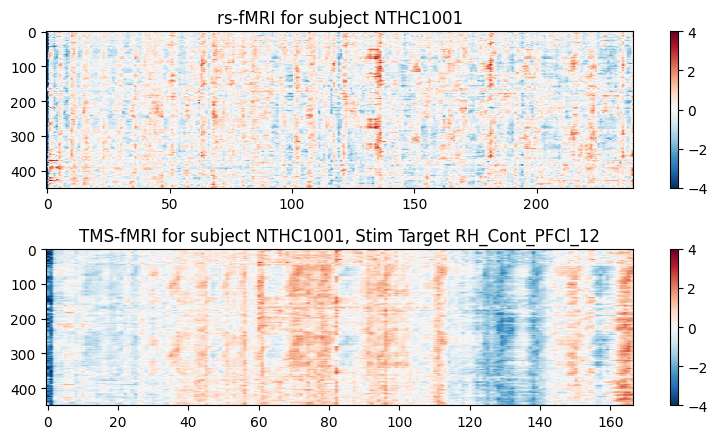

In [ ]:
from scipy import stats
import matplotlib.pyplot as plt

plt.figure(figsize=(8,4.5))
plt.subplot(2,1,1)
plt.title('rs-fMRI for subject %s'%subjects_all[sid])
plt.imshow(stats.zscore(rest_ex).T,
           aspect='auto',cmap='RdBu_r',vmax=4,vmin=-4)
plt.colorbar()
plt.subplot(2,1,2)
plt.title('TMS-fMRI for subject %s, Stim Target %s'%(subjects_all[sid],target_label))
plt.imshow(stats.zscore(task_ex).T,
           aspect='auto',cmap='RdBu_r',vmax=4,vmin=-4)
plt.colorbar()
plt.tight_layout()
plt.show()

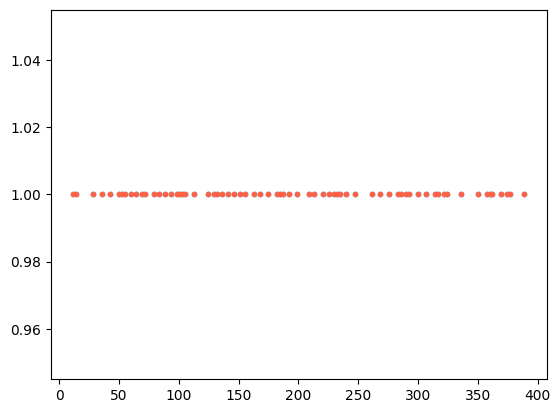

In [ ]:
stimt=dataset['sub-'+subjects_all[sid]]['task-stim'][0]['stim time']['onset']
plt.plot(stimt,np.ones(len(stimt)),'.')
stimt=dataset['sub-'+subjects_all[10]]['task-stim'][0]['stim time']['onset']
plt.plot(stimt,np.ones(len(stimt)),'.',c='tomato')

In [ ]:
dataset['sub-'+subjects_all[sid]]['task-stim'][0]['stim time']['onset']

0      11.8
1      14.2
2      28.6
3      35.8
4      43.0
      ...  
63    362.2
64    369.4
65    374.2
66    376.6
67    388.6
Name: onset, Length: 68, dtype: float64

In [ ]:
nvol=dataset['sub-'+subjects_all[sid]]['task-stim'][0]['metadata']['n_volumes']

In [ ]:
tr=dataset['sub-'+subjects_all[sid]]['task-stim'][0]['metadata']['tr_s']

In [ ]:
np.linspace(0,tr*nvol,nvol+1)[:-1]

array([  0. ,   2.4,   4.8,   7.2,   9.6,  12. ,  14.4,  16.8,  19.2,
        21.6,  24. ,  26.4,  28.8,  31.2,  33.6,  36. ,  38.4,  40.8,
        43.2,  45.6,  48. ,  50.4,  52.8,  55.2,  57.6,  60. ,  62.4,
        64.8,  67.2,  69.6,  72. ,  74.4,  76.8,  79.2,  81.6,  84. ,
        86.4,  88.8,  91.2,  93.6,  96. ,  98.4, 100.8, 103.2, 105.6,
       108. , 110.4, 112.8, 115.2, 117.6, 120. , 122.4, 124.8, 127.2,
       129.6, 132. , 134.4, 136.8, 139.2, 141.6, 144. , 146.4, 148.8,
       151.2, 153.6, 156. , 158.4, 160.8, 163.2, 165.6, 168. , 170.4,
       172.8, 175.2, 177.6, 180. , 182.4, 184.8, 187.2, 189.6, 192. ,
       194.4, 196.8, 199.2, 201.6, 204. , 206.4, 208.8, 211.2, 213.6,
       216. , 218.4, 220.8, 223.2, 225.6, 228. , 230.4, 232.8, 235.2,
       237.6, 240. , 242.4, 244.8, 247.2, 249.6, 252. , 254.4, 256.8,
       259.2, 261.6, 264. , 266.4, 268.8, 271.2, 273.6, 276. , 278.4,
       280.8, 283.2, 285.6, 288. , 290.4, 292.8, 295.2, 297.6, 300. ,
       302.4, 304.8,

# CHECK ALIGNMENT PARCELS

In [ ]:
import os, glob, re
from nilearn.image import load_img, index_img, resample_to_img
from nilearn import plotting

# =========================
# CONFIG
# =========================
BASE_DIR   = "/Volumes/LaCie2/fufo/data/Interim/MSCA/TMS_fMRI"
DERIV_DIR  = os.path.join(BASE_DIR, "derivatives")
SUBJECTS_TXT = os.path.join(BASE_DIR, "subjects_all.txt")

SCHAEFER_PATH = os.path.join(BASE_DIR, "atlases", "Schaefer2018_400Parcels_7Networks_order_FSLMNI152_2mm.nii.gz")
TIAN_PATH     = os.path.join(BASE_DIR, "atlases", "Tian_Subcortex_S3_3T.nii")

# =========================
# LOAD SUBJECT LIST
# =========================
with open(SUBJECTS_TXT, "r") as f:
    subjects_all = [ln.strip() for ln in f if ln.strip() and not ln.strip().startswith("#")]

def to_bids_sub_id(sub_name):
    return sub_name if sub_name.startswith("sub-") else f"sub-{sub_name}"

# =========================
# FIND BOLD AUTOMATICALLY
# =========================
def find_bold_auto(sub_name, task="task-rest"):
    sub_id = to_bids_sub_id(sub_name)
    sub_dir = os.path.join(DERIV_DIR, sub_id)
    if not os.path.isdir(sub_dir):
        raise FileNotFoundError(f"Subject folder not found: {sub_dir}")

    patt = os.path.join(
        sub_dir, "ses-*", "func",
        f"*{task}*_space-MNI152NLin2009cAsym_desc-preproc_bold.nii.gz"
    )
    hits = sorted(glob.glob(patt))
    if not hits:
        raise FileNotFoundError(f"No BOLD files found for {sub_id} with task={task}\nPattern:\n{patt}")

    bold_path = hits[0]
    ses_id = os.path.basename(os.path.dirname(os.path.dirname(bold_path)))

    stim_coords = None
    if task == "task-stim":
        fname = os.path.basename(bold_path)
        m = re.search(r"task-stim(\-?\d+)x(\-?\d+)x(\-?\d+)", fname)
        stim_coords = tuple(map(int, m.groups())) if m else None

    return bold_path, ses_id, stim_coords

# =========================
# PLOT ALIGNMENT (Schaefer + Tian, same cmap)
# =========================
def plot_alignment_auto(
    sub_name,
    task="task-rest",
    alpha_parcels=0.6,
    display_mode="ortho",
    cut_coords=(0, 0, 0),
    show_contours=True
):
    bold_path, ses_id, stim_coords = find_bold_auto(sub_name, task=task)

    bold_4d = load_img(bold_path)
    bold_3d = index_img(bold_4d, 0)

    sch = load_img(SCHAEFER_PATH)
    tian = load_img(TIAN_PATH)

    sch_rs = resample_to_img(sch, bold_3d, interpolation="nearest")
    tian_rs = resample_to_img(tian, bold_3d, interpolation="nearest")

    sub_id = to_bids_sub_id(sub_name)
    stim_str = f" | stim @ MNI {stim_coords}" if (task == "task-stim" and stim_coords is not None) else ""
    title = f"{sub_id} | {ses_id} | {task}{stim_str}\nfirst volume: {os.path.basename(bold_path)}"

    disp = plotting.plot_epi(
        bold_3d,
        cmap="gray",
        title=title,
        display_mode=display_mode,
        cut_coords=cut_coords,
        colorbar=False
    )

    # Same categorical cmap for BOTH atlases
    disp.add_overlay(sch_rs, cmap="tab20", transparency=alpha_parcels, colorbar=False)
    disp.add_overlay(tian_rs, cmap="tab20", transparency=alpha_parcels, colorbar=False)

    if show_contours:
        disp.add_contours(sch_rs, levels=[0.5], colors="black", linewidths=0.4)
        disp.add_contours(tian_rs, levels=[0.5], colors="black", linewidths=0.7)  # slightly thicker for subcortex

    plotting.show()

# Example:
# plot_alignment_auto(subjects_all[0], task="task-rest", cut_coords=(0,0,0))
# plot_alignment_auto(subjects_all[0], task="task-stim", cut_coords=(0,0,0))


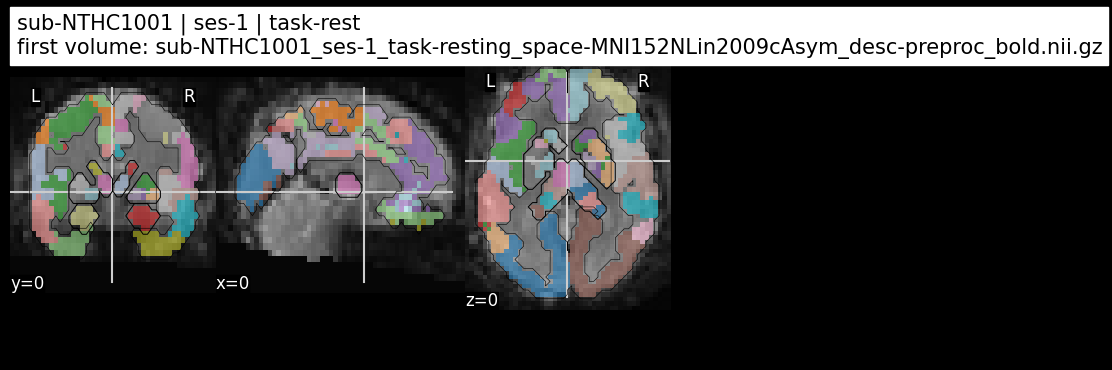

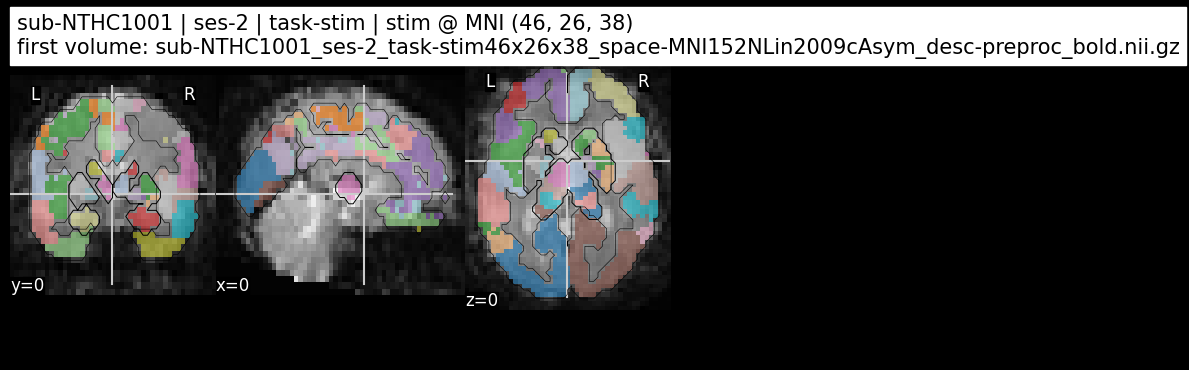

In [ ]:
# =========================
# EXAMPLES
# =========================
plot_alignment_auto(subjects_all[0], task="task-rest", cut_coords=(0,0,0))
plot_alignment_auto(subjects_all[0], task="task-stim", cut_coords=(0,0,0))
